In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import words
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
import time
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, Activation
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from gensim.models import KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from datetime import datetime
from sklearn.metrics import classification_report
import os

In [4]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [5]:
#pip install C:\\Users\\super\\OneDrive\\fastText-0.9.2

In [2]:
data = pd.read_csv("lemma_clean.csv")

In [3]:
data

,label,text_lemma
0,0.0,murdoch toxic sexist culture exposed former em...
1,0.0,hello i love
2,0.0,i miss sweet tea
3,0.0,i can not believe eye working grad school
4,0.0,soul man spiritual path sobriety week
...,...,...
199829,1.0,looking friend talk relateable level anywhere ...
199830,1.0,i feel like i should killed myself year ago i ...
199831,1.0,anyone else like i wanted see anyone else felt...
199832,1.0,leaving need place rant i want fucking kill my...


In [5]:
# Load the English words corpus
nltk.download('words')
english_words = set(words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [6]:
# Function to filter out non-existing words
def filter_non_existing_words(text):
    words_list = text.split()
    filtered_words = [word for word in words_list if word.lower() in english_words]
    return ' '.join(filtered_words)

In [7]:
data['text_tostring'] = data['text_lemma'].apply(lambda x: str(x))

In [8]:
data['text_tostring'] = data['text_tostring'].apply(filter_non_existing_words)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['text_tostring'], 
                                                          data['label'], 
                                                          stratify=data['label'],
                                                          random_state = 42, 
                                                          test_size=0.2)

In [10]:
X_train

142082    i decided i would counselor problem advice wor...
159903      difference believing millennial unsure supposed
186772    i revenge i hurt i tell word towards head wate...
197213    broke heart dating nearly seven month i could ...
57641     annoying part feeling like not should everyone...
                                ...                        
152826    i not anything life far i want preface little ...
175788    thought life not suicidal i really hate cultur...
164701    sympathize extremely negative friend since pos...
53009                                                  find
62402                                               academy
Name: text_tostring, Length: 159867, dtype: object

In [11]:
X_test

44872                           should not need feel better
178936    not much i want die much really i not think i ...
72278     strict basically i want know whether not stric...
9596                                        different gravy
117766    anyone else loss appetite period i i female fr...
                                ...                        
84453                   time kick play arsonist simulator i
100875    i think dumb enforce gender role show role rea...
107124    honker ever yes honker delightful soft plump j...
60334                                                      
3439              working incredibly hard week shut weekend
Name: text_tostring, Length: 39967, dtype: object

In [14]:
# Checking if splitting is balanced
class_counts = pd.Series(y_train).value_counts()
class_proportions = class_counts / len(X_train)
class_proportions

1.0    0.500266
0.0    0.499734
Name: label, dtype: float64

In [15]:
data[data['text_tostring'].str.contains('aaffffffff')]

,label,text_lemma,text_tostring


In [16]:
MAX_LEN = 200 # Maximum number of words in a comment to be used.
NUM_WORDS = 5000 # Number of unique words to be used.
WORD_VEC_SIZE = 100 # Size of each word vector.

In [17]:
import fasttext
model_ft = fasttext.train_supervised('train.txt', wordNgrams = 2)

In [18]:
train_vectors = []
for sentence in X_train:
    train_vectors.append(model_ft.get_sentence_vector(sentence))

In [19]:
test_vectors = []
for sentence in X_test:
    test_vectors.append(model_ft.get_sentence_vector(sentence))

In [20]:
# # Convert NumPy arrays to lists of strings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, truncating='post' , padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, truncating='post' , padding='post')

In [21]:
word_to_index = tokenizer.word_index

In [22]:
vocab_size = len(tokenizer.word_index) + 1

In [23]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = model_ft.get_dimension()

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in word_to_index.items():
    if word in model_ft:
        embedding_matrix[index] = model_ft.get_word_vector(word)

In [22]:
# glove_dictionary = dict()
# with open("glove.twitter.27B.100d.txt", encoding="utf8") as f:
#     for line in f:
#         line = line.split()
#         word, coefficients = line[0], line[1:]
#         glove_dictionary[word] = np.asarray(coefficients, dtype='float32')

In [26]:
def build_model(embedding_matrix):
    """
    Build the LSTM model.
    
    :param embedding_matrix: a matrix with the corresponding embedding of all words.
    :return: the created LSTM model.
    """
    optimzer=Adam(learning_rate=1e-5)
    # Input layer.
    inp = tf.keras.layers.Input(shape=(MAX_LEN,), name="input")

    # Add embedding layer.
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                                  weights=[embedding_matrix], 
                                  trainable=False, mask_zero=True)(inp)

    # Add LSTM layer.
    x = tf.keras.layers.LSTM(128)(x)

    # Output layer.
    x = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=x)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimzer, 
                  metrics=['accuracy'])
                  
    return model

In [34]:
model = build_model(embedding_matrix)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          2297400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 2,414,777
Trainable params: 117,377
Non-trainable params: 2,297,400
_________________________________________________________________


In [ ]:
#pip install graphviz
#pip install pydot

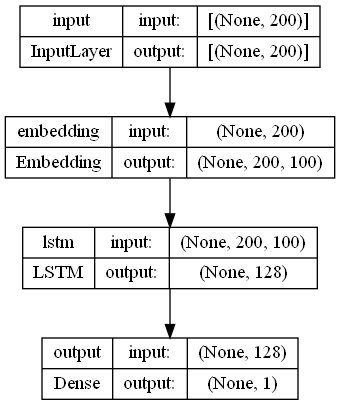

In [35]:
tf.keras.utils.plot_model(model, to_file='LSTM_model.png', show_shapes=True, 
                          show_dtype=False, show_layer_names=True, dpi=96)

In [36]:
history = model.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
1000/1000 [==============================] - 368s 364ms/step - loss: 0.5278 - accuracy: 0.8172 - val_loss: 0.3929 - val_accuracy: 0.8726
Epoch 2/15
1000/1000 [==============================] - 369s 369ms/step - loss: 0.3613 - accuracy: 0.8785 - val_loss: 0.3523 - val_accuracy: 0.8752
Epoch 3/15
1000/1000 [==============================] - 363s 364ms/step - loss: 0.3347 - accuracy: 0.8800 - val_loss: 0.3367 - val_accuracy: 0.8763
Epoch 4/15
1000/1000 [==============================] - 363s 363ms/step - loss: 0.3248 - accuracy: 0.8802 - val_loss: 0.3289 - val_accuracy: 0.8774
Epoch 5/15
1000/1000 [==============================] - 359s 359ms/step - loss: 0.3184 - accuracy: 0.8810 - val_loss: 0.3243 - val_accuracy: 0.8780
Epoch 6/15
1000/1000 [==============================] - 360s 360ms/step - loss: 0.3141 - accuracy: 0.8811 - val_loss: 0.3204 - val_accuracy: 0.8771
Epoch 7/15
1000/1000 [==============================] - 358s 358ms/step - loss: 0.3111 - accuracy: 0.8815 - val_

In [4]:
# # Add 10 more epochs to the existing history
# extended_history = model.fit(X_train_padded, y_train.ravel(), epochs=20, batch_size=128, verbose=1, validation_split=0.2)

# # Combine the histories
# combined_history = {}
# combined_history['loss'] = history.history['loss'] + extended_history.history['loss']
# combined_history['accuracy'] = history.history['accuracy'] + extended_history.history['accuracy']
# combined_history['val_loss'] = history.history['val_loss'] + extended_history.history['val_loss']
# combined_history['val_accuracy'] = history.history['val_accuracy'] + extended_history.history['val_accuracy']

In [37]:
_, accuracy  = model.evaluate(X_test_padded, y_test.ravel(), verbose=1)

1249/1249 [==============================] - 138s 111ms/step - loss: 0.3222 - accuracy: 0.8735


In [38]:
model.save('fasttext_model.h5')

In [7]:
# import pickle

# # Save the history object to a file
# with open('history_w2v.pkl', 'wb') as file:
#     pickle.dump(history.history, file)

### Possible improvment

In [28]:
# Stack multiple recurrent layers:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True),
    tf.keras.layers.LSTM(128, return_sequences=True),  # This LSTM will return sequences
    tf.keras.layers.LSTM(64),  # This LSTM will return the last output only
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

In [29]:
history1 = model1.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
1000/1000 [==============================] - 693s 685ms/step - loss: 0.3158 - accuracy: 0.8771 - val_loss: 0.3077 - val_accuracy: 0.8809
Epoch 2/15
1000/1000 [==============================] - 674s 674ms/step - loss: 0.2912 - accuracy: 0.8834 - val_loss: 0.3014 - val_accuracy: 0.8797
Epoch 3/15
1000/1000 [==============================] - 654s 654ms/step - loss: 0.2866 - accuracy: 0.8841 - val_loss: 0.2967 - val_accuracy: 0.8824
Epoch 4/15
1000/1000 [==============================] - 646s 646ms/step - loss: 0.2838 - accuracy: 0.8853 - val_loss: 0.2927 - val_accuracy: 0.8819
Epoch 5/15
1000/1000 [==============================] - 657s 657ms/step - loss: 0.2822 - accuracy: 0.8855 - val_loss: 0.2925 - val_accuracy: 0.8821
Epoch 6/15
1000/1000 [==============================] - 652s 652ms/step - loss: 0.2814 - accuracy: 0.8862 - val_loss: 0.2891 - val_accuracy: 0.8838
Epoch 7/15
1000/1000 [==============================] - 658s 658ms/step - loss: 0.2801 - accuracy: 0.8862 - val_

In [31]:
model1.save('fasttext_model_2layers.h5')

In [33]:
import pickle

# After training the model and obtaining the `history1` object
history_file = 'history1.pkl'
with open(history_file, 'wb') as file:
    pickle.dump(history1.history, file)

In [ ]:
# import pickle

# history_file = 'history1.pkl'
# with open(history_file, 'rb') as file:
#     loaded_history1 = pickle.load(file)


In [30]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True),
    tf.keras.layers.LSTM(128, return_sequences=True),  # This LSTM will return sequences
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    tf.keras.layers.LSTM(64),  # This LSTM will return the last output only
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
history2 = model2.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
1000/1000 [==============================] - 712s 704ms/step - loss: 0.3166 - accuracy: 0.8776 - val_loss: 0.2999 - val_accuracy: 0.8802
Epoch 2/15
1000/1000 [==============================] - 663s 663ms/step - loss: 0.3001 - accuracy: 0.8807 - val_loss: 0.3041 - val_accuracy: 0.8811
Epoch 3/15
1000/1000 [==============================] - 664s 665ms/step - loss: 0.2891 - accuracy: 0.8839 - val_loss: 0.2932 - val_accuracy: 0.8828
Epoch 4/15
1000/1000 [==============================] - 664s 665ms/step - loss: 0.2869 - accuracy: 0.8847 - val_loss: 0.2977 - val_accuracy: 0.8791
Epoch 5/15
1000/1000 [==============================] - 668s 668ms/step - loss: 0.2853 - accuracy: 0.8851 - val_loss: 0.2941 - val_accuracy: 0.8811
Epoch 6/15
1000/1000 [==============================] - 665s 665ms/step - loss: 0.2832 - accuracy: 0.8856 - val_loss: 0.2899 - val_accuracy: 0.8837
Epoch 7/15
1000/1000 [==============================] - 666s 666ms/step - loss: 0.2823 - accuracy: 0.8858 - val_

In [32]:
model2.save('fasttext_model_2landDropout.h5')

In [34]:
import pickle

# After training the model and obtaining the `history1` object
history_file = 'history2.pkl'
with open(history_file, 'wb') as file:
    pickle.dump(history1.history, file)

In [ ]:
# different optimizers
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [ ]:
# hyperparameters tuning including:

# The number of LSTM units (64, 128, 256, 512)
# The activation function ('tanh', 'relu')
# The recurrent activation function ('sigmoid', 'hard_sigmoid')
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True),
    tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh', recurrent_activation='hard_sigmoid'),  # First LSTM layer
    tf.keras.layers.LSTM(512, activation='relu', recurrent_activation='sigmoid'),  # Second LSTM layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### MODEL3

In [23]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, WORD_VEC_SIZE, input_length=X_train_padded.shape[1]),
    tf.keras.layers.LSTM(128, return_sequences=True),  # This LSTM will return sequences
    tf.keras.layers.Dropout(0.2),  # Add dropout layer with dropout rate of 0.2
    tf.keras.layers.LSTM(64),  # This LSTM will return the last output only
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model3.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
history3 = model3.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
1000/1000 [==============================] - 618s 614ms/step - loss: 0.5816 - accuracy: 0.6735 - val_loss: 0.3466 - val_accuracy: 0.8668
Epoch 2/15
1000/1000 [==============================] - 635s 635ms/step - loss: 0.3168 - accuracy: 0.8788 - val_loss: 0.3118 - val_accuracy: 0.8818
Epoch 3/15
1000/1000 [==============================] - 611s 611ms/step - loss: 0.2709 - accuracy: 0.8965 - val_loss: 0.3093 - val_accuracy: 0.8801
Epoch 4/15
1000/1000 [==============================] - 614s 614ms/step - loss: 0.2398 - accuracy: 0.9076 - val_loss: 0.3173 - val_accuracy: 0.8750
Epoch 5/15
1000/1000 [==============================] - 627s 627ms/step - loss: 0.2152 - accuracy: 0.9170 - val_loss: 0.3378 - val_accuracy: 0.8726
Epoch 6/15
1000/1000 [==============================] - 624s 624ms/step - loss: 0.1927 - accuracy: 0.9256 - val_loss: 0.3476 - val_accuracy: 0.8716
Epoch 7/15
1000/1000 [==============================] - 628s 628ms/step - loss: 0.1735 - accuracy: 0.9323 - val_

In [5]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [6]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [11]:
tf.test.is_built_with_cuda()

False

In [4]:
tf.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, WORD_VEC_SIZE, input_length=X_train_padded.shape[1]),
    tf.keras.layers.LSTM(256, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', dropout=0),  # First LSTM layer
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.LSTM(512, activation='tanh', recurrent_activation='sigmoid', dropout=0),  # Second LSTM layer
    tf.keras.layers.Dropout(0.2),  # Add another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
history4 = model4.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
  26/1000 [..............................] - ETA: 1:14:37 - loss: 0.6902 - accuracy: 0.5472

In [52]:
def build_model_simple(embedding_matrix):
    """
    Build the LSTM model.
    
    :param embedding_matrix: a matrix with the corresponding embedding of all words.
    :return: the created LSTM model.
    """
    # Input layer.
    inp = tf.keras.layers.Input(shape=(MAX_LEN,), name="input")

    # Add embedding layer.
    x = tf.keras.layers.Embedding(vocab_size, WORD_VEC_SIZE, 
                                  weights=[embedding_matrix], 
                                  trainable=False)(inp)

    # Add LSTM layer.
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer.
    x = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['acc'])
                  
    return model

In [53]:
model0 = build_model_simple(embedding_matrix)

In [54]:
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
history0 = model0.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
1000/1000 [==============================] - 676s 673ms/step - loss: 0.4124 - accuracy: 0.8478 - val_loss: 0.3864 - val_accuracy: 0.8559
Epoch 2/15
1000/1000 [==============================] - 695s 695ms/step - loss: 0.5349 - accuracy: 0.7125 - val_loss: 0.3726 - val_accuracy: 0.8646
Epoch 3/15
1000/1000 [==============================] - 709s 709ms/step - loss: 0.5078 - accuracy: 0.7318 - val_loss: 0.6583 - val_accuracy: 0.6312
Epoch 4/15
1000/1000 [==============================] - 690s 690ms/step - loss: 0.3783 - accuracy: 0.8462 - val_loss: 0.3266 - val_accuracy: 0.8773
Epoch 5/15
1000/1000 [==============================] - 647s 647ms/step - loss: 0.3077 - accuracy: 0.8783 - val_loss: 0.3002 - val_accuracy: 0.8802
Epoch 6/15
1000/1000 [==============================] - 656s 656ms/step - loss: 0.2993 - accuracy: 0.8809 - val_loss: 0.3107 - val_accuracy: 0.8740
Epoch 7/15
1000/1000 [==============================] - 619s 619ms/step - loss: 0.2953 - accuracy: 0.8817 - val_

In [29]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, WORD_VEC_SIZE, input_length=X_train_padded.shape[1]),
    tf.keras.layers.LSTM(32, return_sequences=True),  # This LSTM will return sequences
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),  # This LSTM will return the last output only
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history5 = model5.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/15
1000/1000 [==============================] - 451s 448ms/step - loss: 0.6155 - accuracy: 0.6528 - val_loss: 0.4276 - val_accuracy: 0.8307
Epoch 2/15
1000/1000 [==============================] - 485s 485ms/step - loss: 0.3322 - accuracy: 0.8727 - val_loss: 0.3115 - val_accuracy: 0.8797
Epoch 3/15
1000/1000 [==============================] - 489s 489ms/step - loss: 0.2780 - accuracy: 0.8932 - val_loss: 0.3126 - val_accuracy: 0.8775
Epoch 4/15
1000/1000 [==============================] - 472s 472ms/step - loss: 0.2450 - accuracy: 0.9044 - val_loss: 0.3110 - val_accuracy: 0.8832
Epoch 5/15
1000/1000 [==============================] - 471s 471ms/step - loss: 0.2182 - accuracy: 0.9149 - val_loss: 0.3357 - val_accuracy: 0.8723
Epoch 6/15
1000/1000 [==============================] - 476s 476ms/step - loss: 0.1959 - accuracy: 0.9233 - val_loss: 0.3510 - val_accuracy: 0.8734
Epoch 7/15
1000/1000 [==============================] - 475s 475ms/step - loss: 0.1779 - accuracy: 0.9304 - val_

In [ ]:
import pickle

# Save the model
# model.save("LSTM_ontext_results/model.h5")
model0.save("LSTM_fasttext/model1.h5")
model2.save("LSTM_fasttext/model2.h5")
model4.save("LSTM_fasttext/model4.h5")
model5.save("LSTM_fasttext/model5.h5")
# # Save the training history
# with open("LSTM_ontext_results/history.pkl", "wb") as f:
#     pickle.dump(history.history, f)
    
with open("LSTM_fasttext/history0.pkl", "wb") as f:
    pickle.dump(history1.history, f)
    
with open("LSTM_fasttext/history3.pkl", "wb") as f:
    pickle.dump(history2.history, f)

with open("LSTM_fasttext/history4.pkl", "wb") as f:
    pickle.dump(history4.history, f)
    

with open("LSTM_fasttext/history5.pkl", "wb") as f:
    pickle.dump(history4.history, f)

### MODEL3

In [24]:
def build_model_simple(embedding_matrix):
    """
    Build the LSTM model.
    
    :param embedding_matrix: a matrix with the corresponding embedding of all words.
    :return: the created LSTM model.
    """
    # Input layer.
    inp = tf.keras.layers.Input(shape=(MAX_LEN,), name="input")

    # Add embedding layer.
    x = tf.keras.layers.Embedding(vocab_size, WORD_VEC_SIZE, 
                                  weights=[embedding_matrix], 
                                  trainable=False)(inp)

    # Add LSTM layer.
    x = tf.keras.layers.LSTM(128)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer.
    x = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=x)
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['acc'])
                  
    return model

In [26]:
model0 = build_model_simple(embedding_matrix)
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
history0 = model0.fit(X_train_padded, y_train.ravel(), epochs=15, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/15
1000/1000 [==============================] - 321s 319ms/step - loss: 0.5484 - accuracy: 0.7144 - val_loss: 0.3839 - val_accuracy: 0.8524
Epoch 2/15
1000/1000 [==============================] - 336s 336ms/step - loss: 0.3351 - accuracy: 0.8722 - val_loss: 0.3046 - val_accuracy: 0.8805
Epoch 3/15
1000/1000 [==============================] - 340s 340ms/step - loss: 0.3013 - accuracy: 0.8820 - val_loss: 0.3002 - val_accuracy: 0.8814
Epoch 4/15
1000/1000 [==============================] - 341s 341ms/step - loss: 0.2951 - accuracy: 0.8837 - val_loss: 0.2980 - val_accuracy: 0.8823
Epoch 5/15
1000/1000 [==============================] - 348s 349ms/step - loss: 0.2920 - accuracy: 0.8844 - val_loss: 0.2958 - val_accuracy: 0.8824
Epoch 6/15
1000/1000 [==============================] - 351s 351ms/step - loss: 0.2887 - accuracy: 0.8849 - val_loss: 0.2936 - val_accuracy: 0.8832
Epoch 7/15
1000/1000 [==============================] - 350s 350ms/step - loss: 0.2883 - accuracy: 0.8850 - val_

In [29]:
import pickle

# Save the model
# model.save("LSTM_ontext_results/model.h5")
model0.save("LSTM_fasttext/model0.h5")

with open("LSTM_fasttext/history0.pkl", "wb") as f:
    pickle.dump(history0.history, f)

1249/1249 [==============================] - 113s 90ms/step


<Axes: >

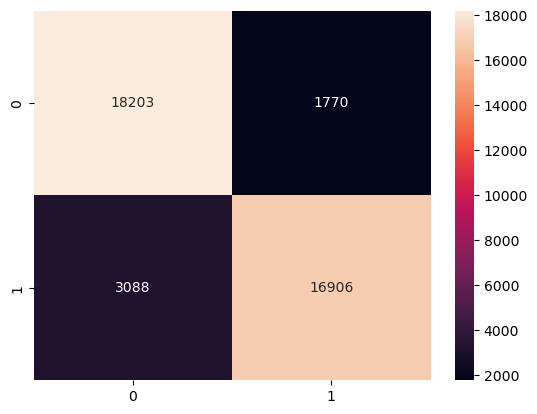

In [31]:
from sklearn.metrics import confusion_matrix

y_pred = model0.predict(X_test_padded)
y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')

In [32]:
TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"True Negatives: {TN}")
print(f"False Positives: {FP}")
print(f"False Negatives: {FN}")

True Positives: 16906
True Negatives: 18203
False Positives: 1770
False Negatives: 3088


In [33]:
# Given values
true_positives = TP
true_negatives = TN
false_positives = FP
false_negatives = FN

# Calculate metrics
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the calculated metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Specificity:", specificity)
print("F1 Score:", f1_score)

Accuracy: 0.8784497210198414
Precision: 0.9052259584493467
Recall: 0.84555366609983
Specificity: 0.9113803634907125
F1 Score: 0.8743728988880269
